# Epidemic Emergence Index

In this notebook we will compose an index out of all the different input layers that attempts to capture the risk of a new disease being transmited to humans through zoonosis.

In [219]:
import numpy as np
import pickle
from pathlib import Path
import json
import scipy
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [29]:
inputs = ["mammals", #
          "cultivated", #
          "urban", #
          "floods",
          "fires",
          "wetmarkets", #
          "gdp",#
          "deforestation", # 
          "pastures", #
          "treecover", 
          "population"] #

In [216]:
def save_outputs(array, name, location, value_type="real", round_to=3):
    with open(location/f"{name}.pickle", "wb") as file:
        pickle.dump(array, file)
    array_to_json(array, location/f"{name}.json", value_type=value_type, round_to=round_to)
    plt.imsave(location/f"{name}.jpg", array, cmap="inferno")

In [217]:
def array_to_coords(array, round_to=3, lon_range=(-180, 180), lat_range=(-60, 80), threshold=0, normalize_by=1.):
    norm = array/normalize_by
    lats = np.arange(lat_range[1], lat_range[0], -(lat_range[1] - lat_range[0])/array.shape[0])
    lons = np.arange(lon_range[0], lon_range[1],  (lon_range[1] - lon_range[0])/array.shape[1])
    rows = list()
    rows = [[round(float(lats[i]), round_to), 
             round(float(lons[j]), round_to), 
             round(float(norm[i, j]), round_to)]
            for j in range(array.shape[1]) 
            for i in range(array.shape[0])
            if array[i, j] > threshold]  # Do not store values below or equal to the threshold (e.g. zeroes)
    return rows

In [215]:
def array_to_json(array, destination, value_name="value", value_type="real", 
                  round_to=3, lon_range=(-180, 180), lat_range=(-60, 80), threshold=0, normalize_by=1.):
    data = {}
    fields = [
        {"name": "latitude", "format": "", "type": "real"},
        {"name": "longitude", "format": "", "type": "real"},
        {"name": value_name, "format": "", "type": value_type},
    ]
    data["fields"] = fields
    data["rows"] = array_to_coords(array, 
        round_to=round_to, 
        lon_range=lon_range, 
        lat_range=lat_range, 
        threshold=threshold,
        normalize_by=normalize_by,
    )
    with open(destination, 'w') as file:
        json.dump(data, file)

X1: [deforestation * mammals * demografico]
X2: [deforestation * (pastures + cropland)]
X3: [mammals * pastures * demografico]
X4: [(flood + fires) * demografico]

# Demográfico:
[(1 + A * conv_gorda(wetmarket)) * (sqrt(gdp * population) * urban) ]

A * X1 + B * X2 + C * X3 + D * X4

In [156]:
g1 = lambda x: gaussian_filter(x, 1)
g2 = lambda x: gaussian_filter(x, 2)
g3 = lambda x: gaussian_filter(x, 3)

In [210]:
dem = ( (1 + 5 * g3(layers["urban"])) *
        (1 + 2 * g3(layers["wetmarkets"])) * 
        ((0.01 + g2(layers["gdp"])))**(-1/3.) * (g2(layers["population"]))**(1/2.) 
       )
dem = dem / dem.max()

forest = ( (1 + g2(layers["deforestation"])) * layers["treecover"] )

X1 = (g1(layers["deforestation"]) * layers["mammals"] * dem)                      # 
X2 = (layers["treecover"] * (layers["pastures"] + layers["cultivated"]))  # 
X3 = (layers["mammals"] * layers["pastures"] * dem)                           # 
X4 = (g1(layers["floods"]) + layers["fires"] * dem)                           # 

X1 = X1/X1.max()
X2 = X2/X2.max()
X3 = X3/X3.max()
X4 = X4/X4.max()

parameters = [X1, X2, X3, X4]

zoonotic_factor = (X1 + X2 + X3 + X4) * g3(layers["population"])

In [221]:
save_outputs(X1, "X1", Path("../data/processed/factors"))
save_outputs(X2, "X2", Path("../data/processed/factors"))
save_outputs(X3, "X3", Path("../data/processed/factors"))
save_outputs(X4, "X4", Path("../data/processed/factors"))
save_outputs(dem, "dem", Path("../data/processed/factors"))
save_outputs(zoonotic_factor, "zoonotic_factor", Path("../data/processed/factors"))

In [212]:
plt.imsave(Path("../data/processed")/f"zoonotic_factor.jpg", zoonotic_factor, cmap="inferno")

In [214]:
zoonotic_factor.max()



0.6952518264728631

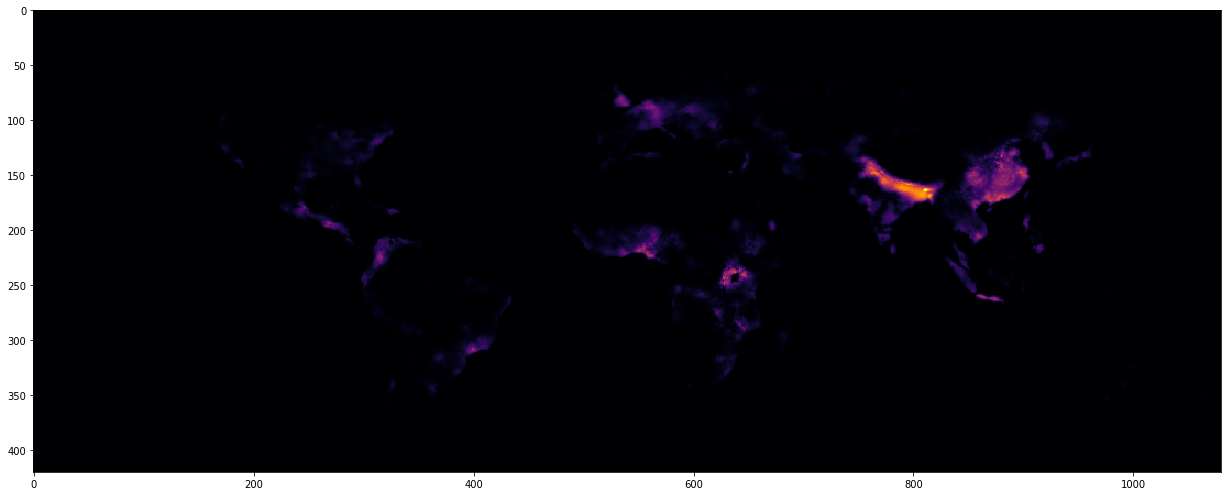

In [211]:
plot_map(zoonotic_factor)

In [195]:
dem.max()

1.0

In [196]:
g3(layers["wetmarkets"]).max()

0.13153687089230826

In [197]:
plt.imsave(Path("../data/processed")/f"dem.jpg", dem, cmap="inferno")

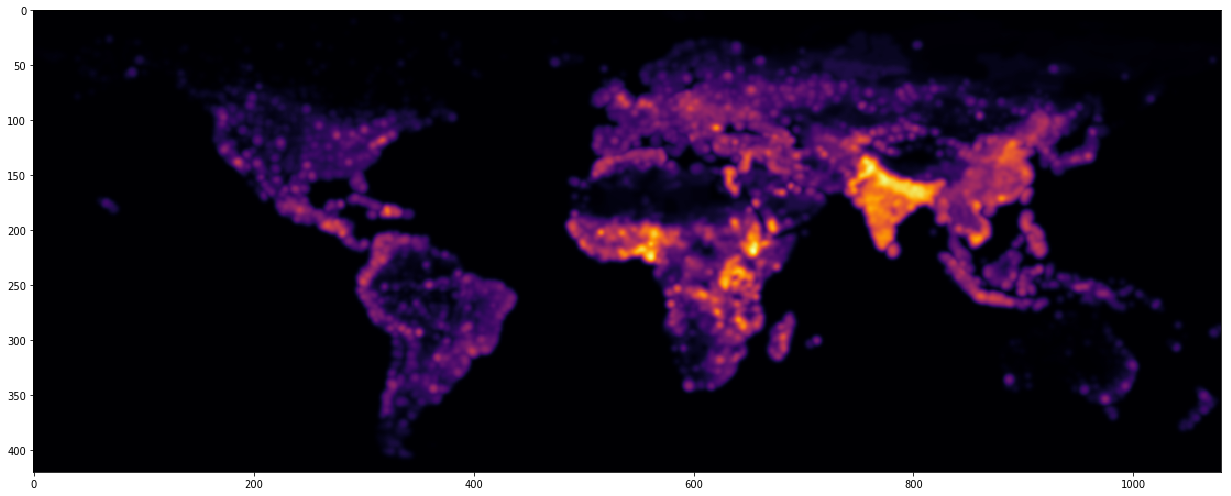

In [198]:
plot_map((dem))

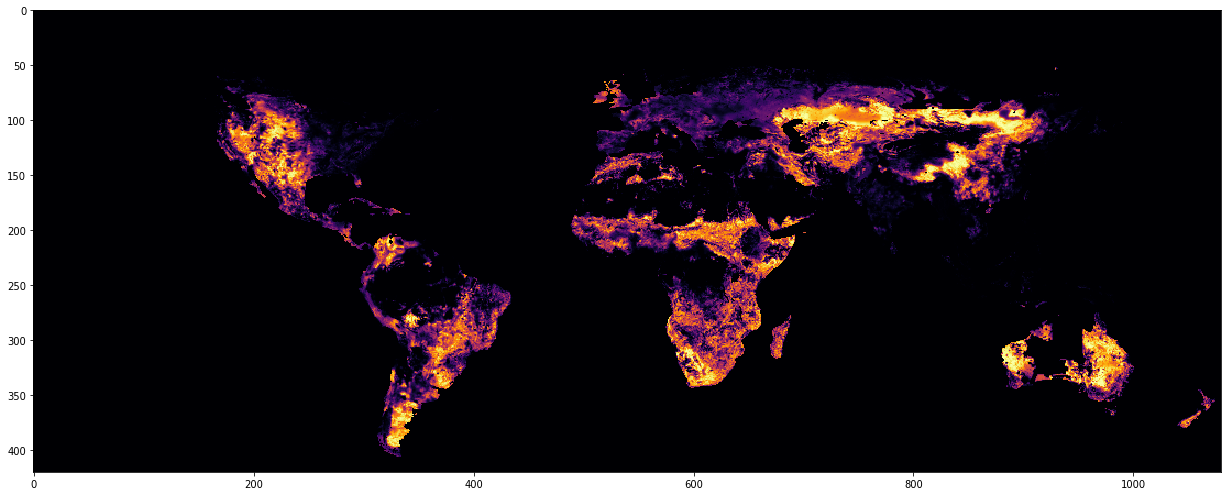

In [199]:
plot_map(layers["pastures"])

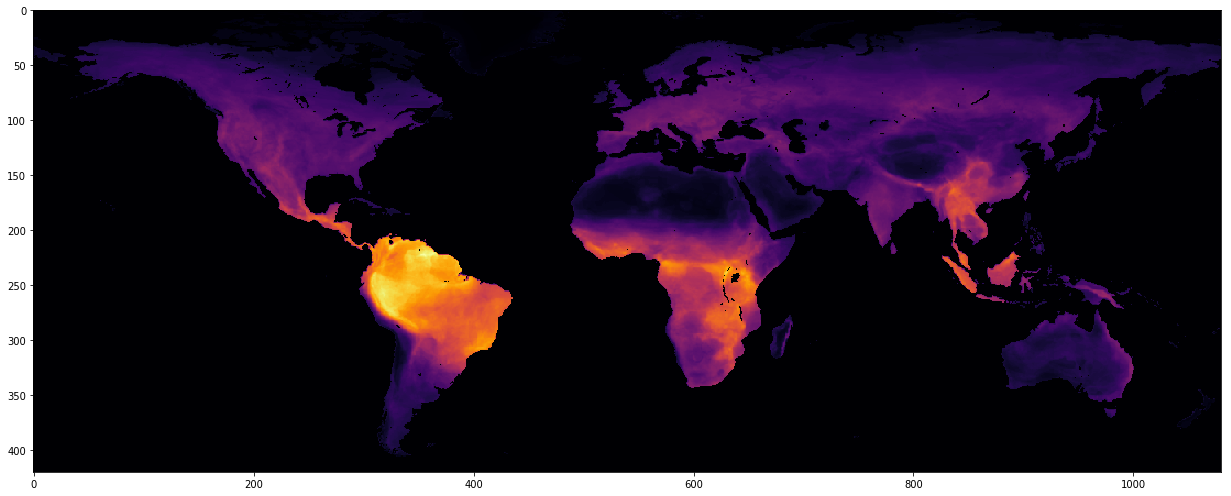

In [200]:
plot_map(layers["mammals"])

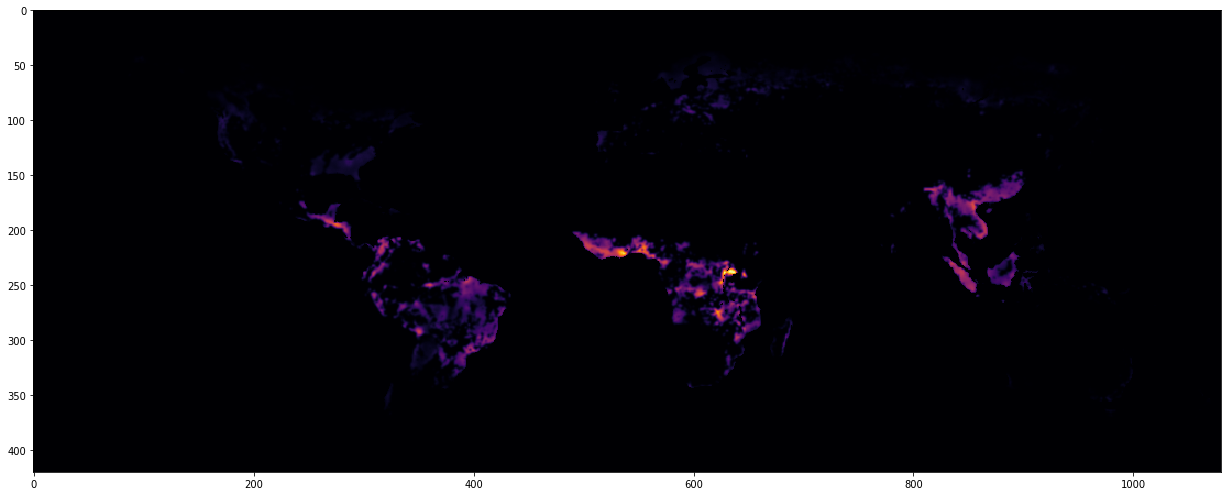

In [201]:
plot_map(X1)

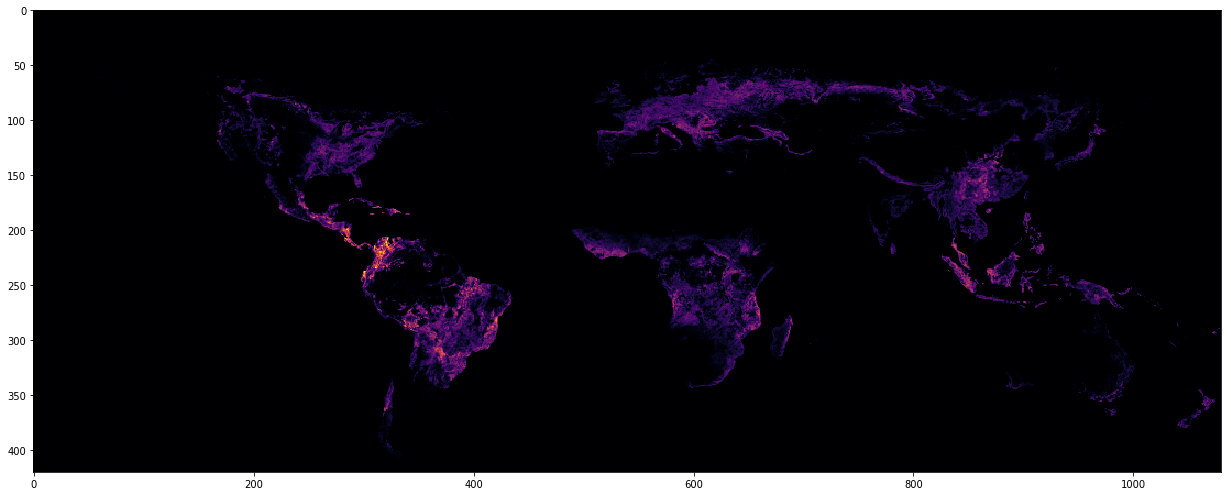

In [202]:
plot_map(X2)

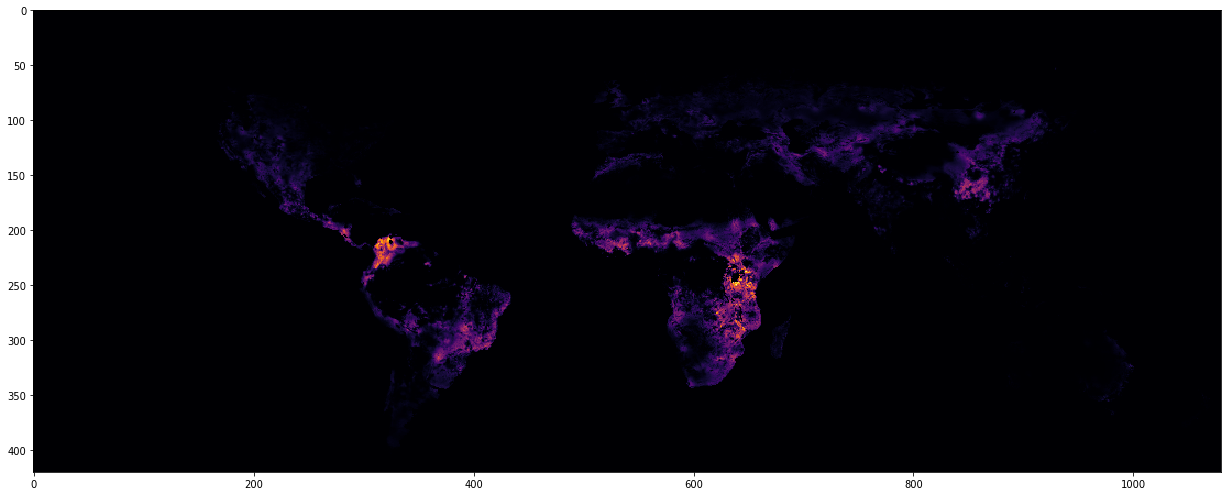

In [203]:
plot_map(X3)

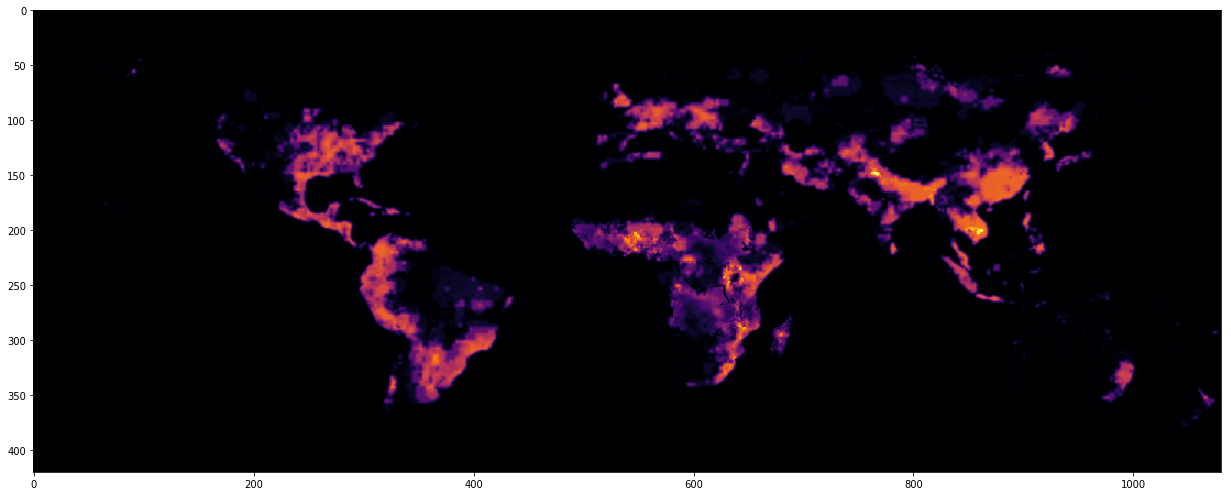

In [204]:
plot_map(X4)

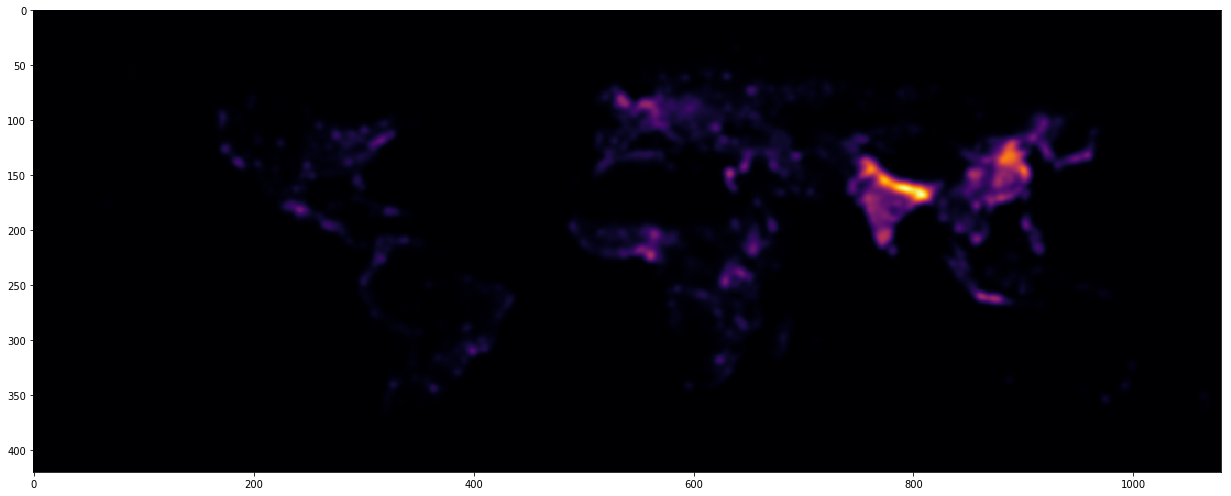

In [205]:
plot_map(g3(layers["population"]))

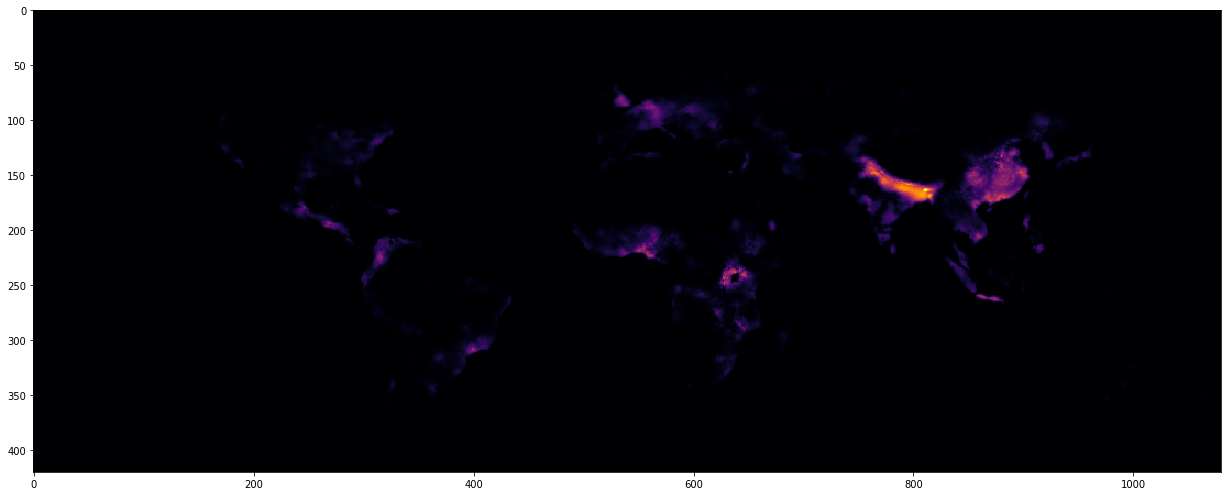

In [206]:
plot_map((X1+X2+X3+X4) * g3(layers["population"]))

In [148]:
print(X1.max())
print(X2.max())
print(X3.max())
print(X4.max())

0.9441624365482234
1.681249966621399
0.8165139510546845
2.0


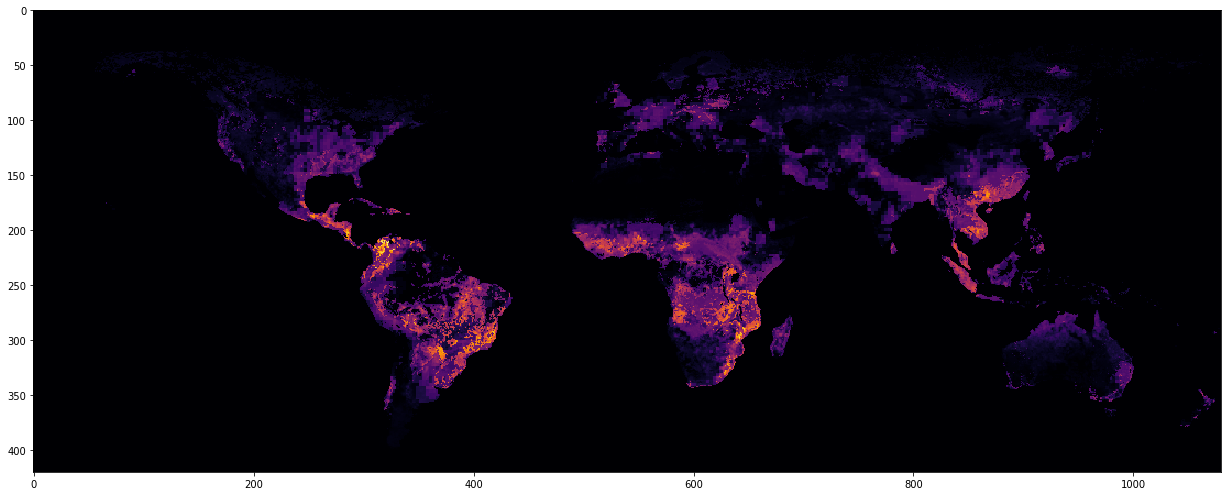

In [147]:
plot_map(X1 + X2 + X3 + X4)

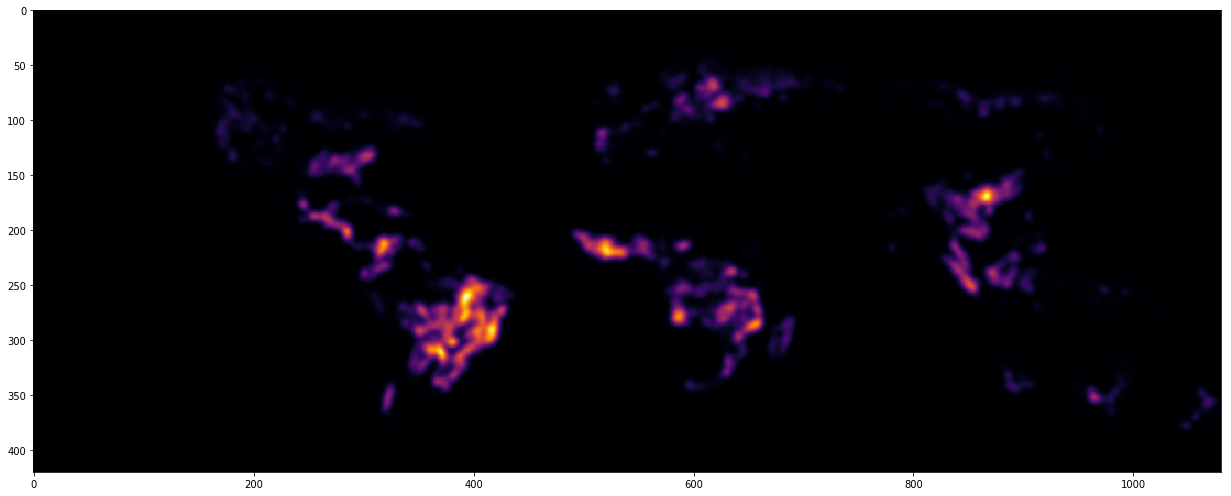

In [82]:
plot_map(gaussian_filter(X2, sigma=3))

In [34]:
def plot_map(array, cmap="inferno", size=18):
    xsize = size
    ysize = size * array.shape[0] / array.shape[1]
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    ax.imshow(array, cmap='inferno')
    plt.tight_layout()

In [30]:
def load_array(name):
    filepath = Path("../data/processed/")/f"{name}/{name}.pickle"
    with filepath.open('rb') as file:
        return pickle.load(file)

In [45]:
def conv(array, filt):
    return convolve2d(array, filt, mode="same", boundary="fill", fillvalue=0)

In [32]:
layers = {}
for name in inputs:
    array = load_array(name)
    layers[name] = array

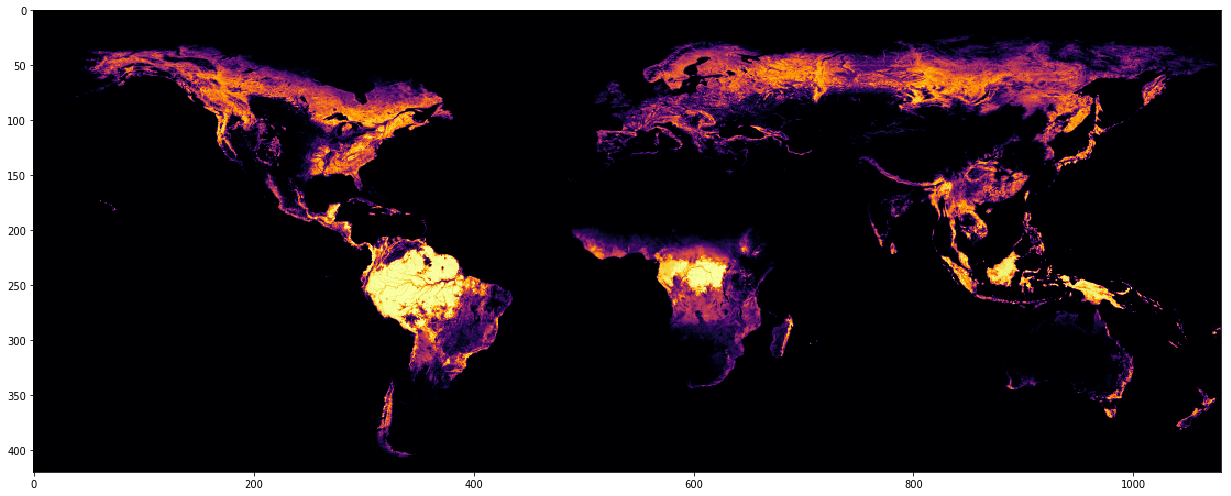

In [37]:
plot_map(layers["treecover"])

In [49]:
test_filter_3 = np.array([
    [2, 3, 2],
    [3, 5, 3],
    [2, 3, 2],
])
test_filter = test_filter_3/test_filter_3.sum()
print(test_filter)

[[0.08 0.12 0.08]
 [0.12 0.2  0.12]
 [0.08 0.12 0.08]]


In [ ]:
test_filter_5 = np.array([
    [1, 3, 2],
    [3, 5, 3],
    [2, 3, 2],
])
test_filter = test_filter_3/test_filter_3.sum()
print(test_filter)

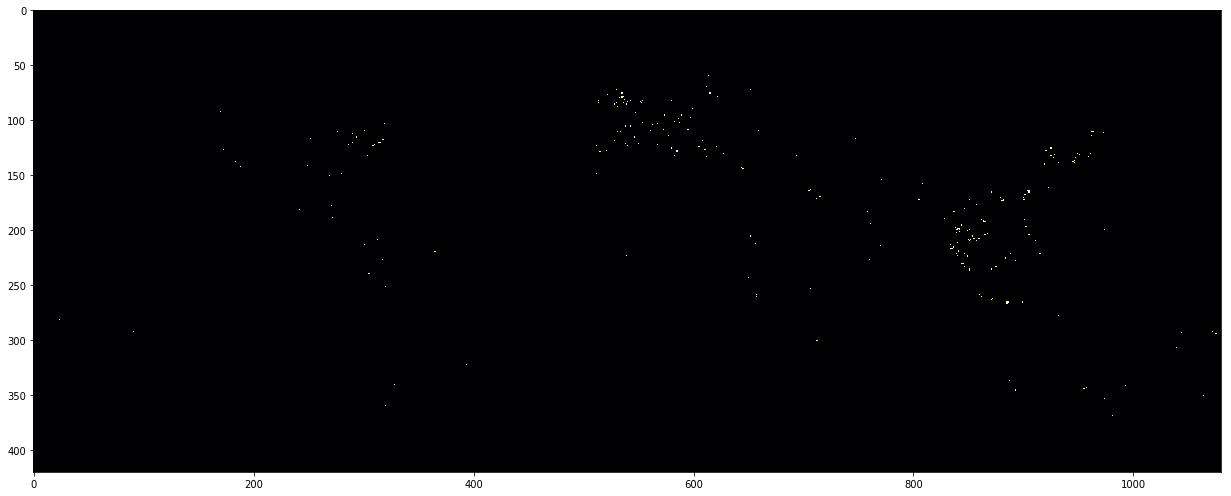

In [51]:
plot_map(layers["wetmarkets"])

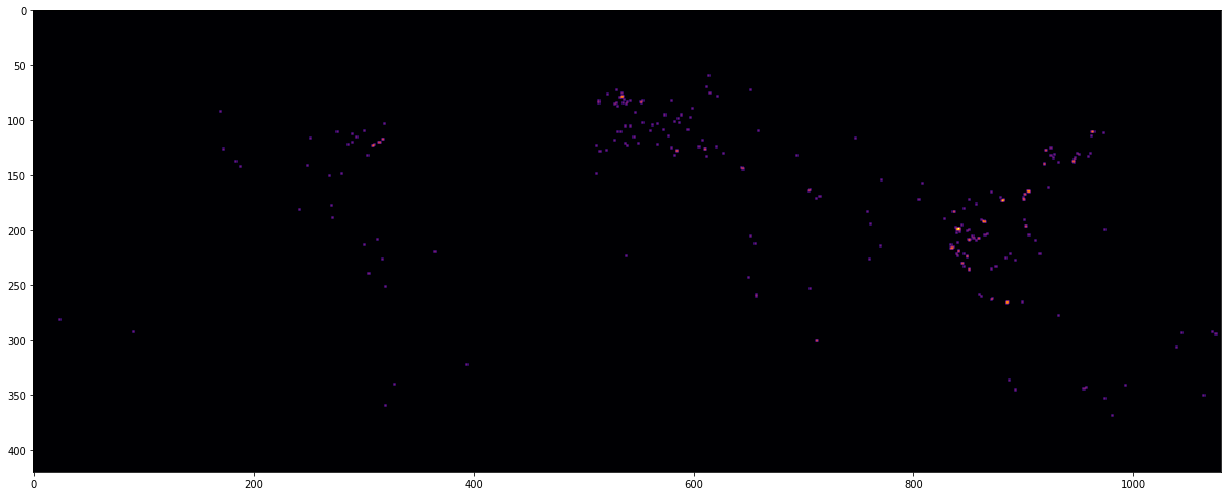

In [50]:
plot_map(conv(layers["wetmarkets"], test_filter_3))

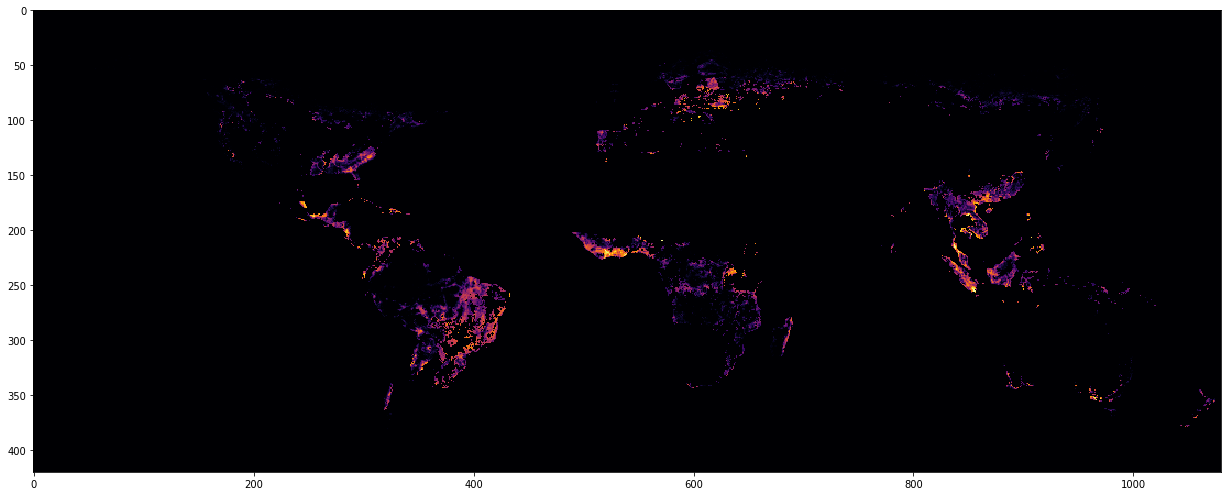

In [57]:
plot_map(layers["deforestation"] * layers["cultivated"])

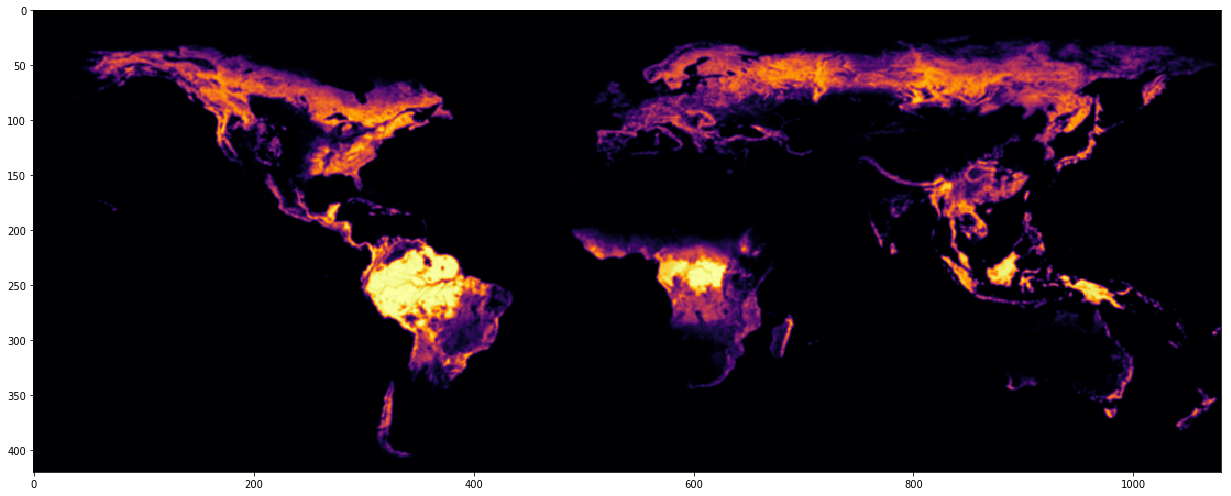

In [53]:
plot_map(conv(layers["treecover"], test_filter_3))

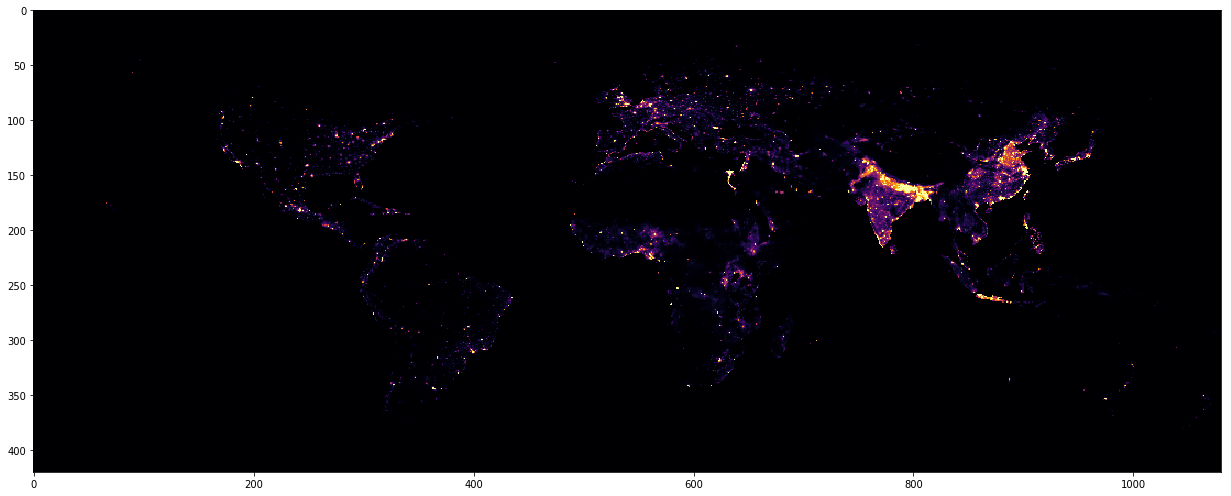

In [58]:
plot_map(layers["population"])

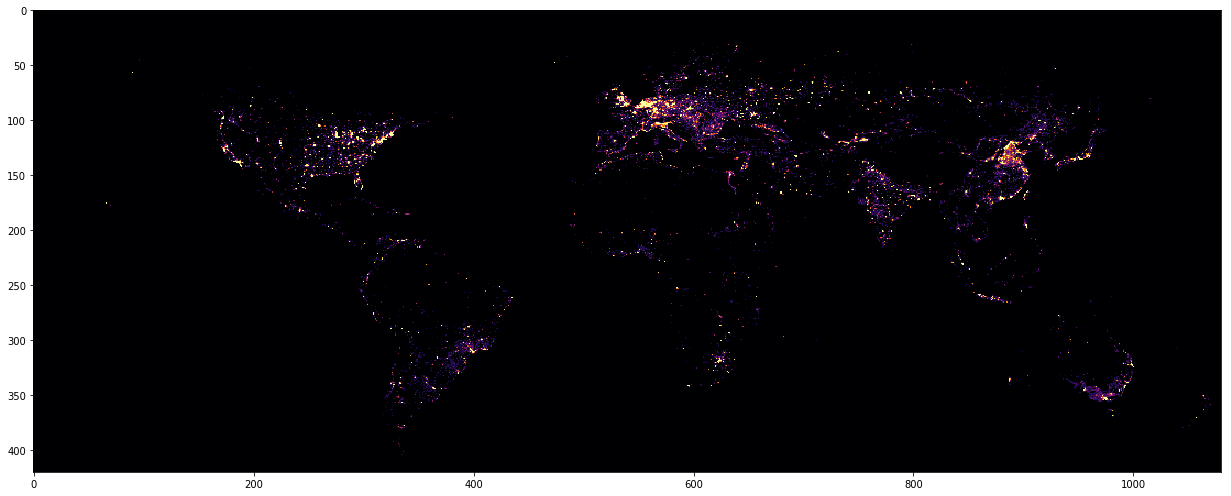

In [61]:
plot_map(np.clip(layers["urban"],0, 0.1))